# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [3]:
# Removing members older than 95

profile = profile[profile.age < 96]

In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
# First things first, let's change the user ids to look more clean.

def id_mapper(column):
    coded_dict = dict()
    counter = 1
    id_encoded = []
    
    for val in column:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded, coded_dict

In [7]:
user_id_encoded, user_coded_dict = id_mapper(profile['id'])

In [8]:
profile['user_id'] = user_id_encoded

In [9]:
del profile['id']

In [10]:
len(user_id_encoded)

14777

In [11]:
offer_id_encoded, offer_coded_dict = id_mapper(portfolio['id'])

In [12]:
portfolio['user_id'] = offer_id_encoded
del portfolio['id']

In [13]:
for val in transcript['value']:
    if 'offer id' in val:
        val['offer id'] = offer_coded_dict.get(val['offer id'])
    else:
        pass

In [14]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': 4}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': 5}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': 10}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 7}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': 2}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 9}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': 6}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': 3}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': 5}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': 5}


In [15]:
for val in transcript['value']:
    if 'offer_id' in val:
        val['offer_id'] = offer_coded_dict.get(val['offer_id'])
    else:
        pass

In [16]:
def code_to_id(val):
    val = user_coded_dict.get(val)
    return val

In [17]:
transcript['person'] = transcript['person'].apply(lambda x: code_to_id(x))

In [18]:
transcript

,event,person,time,value
0,offer received,2.0,0,{'offer id': 4}
1,offer received,NaN,0,{'offer id': 5}
2,offer received,3.0,0,{'offer id': 10}
3,offer received,NaN,0,{'offer id': 7}
4,offer received,NaN,0,{'offer id': 2}
5,offer received,4.0,0,{'offer id': 9}
6,offer received,NaN,0,{'offer id': 6}
7,offer received,5.0,0,{'offer id': 3}
8,offer received,6.0,0,{'offer id': 5}
9,offer received,8.0,0,{'offer id': 5}


In [19]:
del profile['became_member_on']

In [20]:
transcript.rename(columns={'person': 'user_id'}, inplace=True)

In [21]:
df = transcript.merge(profile, on='user_id', how='inner')

In [22]:
df.head()

,event,user_id,time,value,age,gender,income
0,offer received,2.0,0,{'offer id': 4},75,F,100000.0
1,offer viewed,2.0,6,{'offer id': 4},75,F,100000.0
2,transaction,2.0,132,{'amount': 19.89},75,F,100000.0
3,offer completed,2.0,132,"{'offer_id': 4, 'reward': 5}",75,F,100000.0
4,transaction,2.0,144,{'amount': 17.78},75,F,100000.0


In [23]:
for val in df['value']:
    if next(iter(val)) == 'offer_id':
        val['offer id'] = val.pop('offer_id')

In [24]:
df['event'].value_counts()

transaction        123571
offer received      66281
offer viewed        49699
offer completed     32321
Name: event, dtype: int64

In [25]:
# I am going to drop column where gender and income are null

df = df.dropna(subset=['gender', 'income'])

In [26]:
df.shape

(271872, 7)

In [27]:
df_viewed = df[df['event'] == 'offer viewed']

In [28]:
df_viewed

,event,user_id,time,value,age,gender,income
1,offer viewed,2.0,6,{'offer id': 4},75,F,100000.0
6,offer viewed,2.0,216,{'offer id': 8},75,F,100000.0
11,offer viewed,2.0,408,{'offer id': 1},75,F,100000.0
17,offer viewed,2.0,582,{'offer id': 9},75,F,100000.0
19,offer viewed,3.0,18,{'offer id': 10},68,M,70000.0
24,offer viewed,3.0,420,{'offer id': 4},68,M,70000.0
26,offer viewed,3.0,522,{'offer id': 7},68,M,70000.0
31,offer viewed,4.0,0,{'offer id': 9},65,M,53000.0
35,offer viewed,4.0,192,{'offer id': 4},65,M,53000.0
37,offer viewed,4.0,354,{'offer id': 10},65,M,53000.0


In [29]:
df_completed = df[df['event'] == 'offer completed']

In [30]:
df_completed

,event,user_id,time,value,age,gender,income
3,offer completed,2.0,132,"{'reward': 5, 'offer id': 4}",75,F,100000.0
14,offer completed,2.0,510,"{'reward': 10, 'offer id': 1}",75,F,100000.0
15,offer completed,2.0,510,"{'reward': 5, 'offer id': 9}",75,F,100000.0
28,offer completed,3.0,522,"{'reward': 5, 'offer id': 4}",68,M,70000.0
29,offer completed,3.0,522,"{'reward': 2, 'offer id': 7}",68,M,70000.0
33,offer completed,4.0,60,"{'reward': 5, 'offer id': 9}",65,M,53000.0
41,offer completed,4.0,498,"{'reward': 2, 'offer id': 10}",65,M,53000.0
42,offer completed,4.0,498,"{'reward': 5, 'offer id': 4}",65,M,53000.0
48,offer completed,4.0,600,"{'reward': 5, 'offer id': 9}",65,M,53000.0
49,offer completed,4.0,600,"{'reward': 2, 'offer id': 7}",65,M,53000.0


In [31]:
# I will create a column for the offer_id_viewed since it is now inside a dictionary

offer_id_viewed = []

for val in df_viewed['value']:
    offer_id_viewed.append(val['offer id'])

In [32]:
df_viewed['offer_id_viewed'] = offer_id_viewed

C:\Users\amism\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
del df_viewed['value']

In [34]:
df_completed

,event,user_id,time,value,age,gender,income
3,offer completed,2.0,132,"{'reward': 5, 'offer id': 4}",75,F,100000.0
14,offer completed,2.0,510,"{'reward': 10, 'offer id': 1}",75,F,100000.0
15,offer completed,2.0,510,"{'reward': 5, 'offer id': 9}",75,F,100000.0
28,offer completed,3.0,522,"{'reward': 5, 'offer id': 4}",68,M,70000.0
29,offer completed,3.0,522,"{'reward': 2, 'offer id': 7}",68,M,70000.0
33,offer completed,4.0,60,"{'reward': 5, 'offer id': 9}",65,M,53000.0
41,offer completed,4.0,498,"{'reward': 2, 'offer id': 10}",65,M,53000.0
42,offer completed,4.0,498,"{'reward': 5, 'offer id': 4}",65,M,53000.0
48,offer completed,4.0,600,"{'reward': 5, 'offer id': 9}",65,M,53000.0
49,offer completed,4.0,600,"{'reward': 2, 'offer id': 7}",65,M,53000.0


In [35]:
offer_id_completed = []
reward = []
for val in df_completed['value']:
    offer_id_completed.append(val['offer id'])
    reward.append(val['reward'])

In [36]:
df_completed['offer_id_completed'] = offer_id_completed
df_completed['reward'] = reward

C:\Users\amism\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\amism\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
del df_completed['value']

In [38]:
df_completed

,event,user_id,time,age,gender,income,offer_id_completed,reward
3,offer completed,2.0,132,75,F,100000.0,4,5
14,offer completed,2.0,510,75,F,100000.0,1,10
15,offer completed,2.0,510,75,F,100000.0,9,5
28,offer completed,3.0,522,68,M,70000.0,4,5
29,offer completed,3.0,522,68,M,70000.0,7,2
33,offer completed,4.0,60,65,M,53000.0,9,5
41,offer completed,4.0,498,65,M,53000.0,10,2
42,offer completed,4.0,498,65,M,53000.0,4,5
48,offer completed,4.0,600,65,M,53000.0,9,5
49,offer completed,4.0,600,65,M,53000.0,7,2


In [39]:
df_viewed.rename(columns={"time":"time_viewed"}, inplace=True)

C:\Users\amism\anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [40]:
df_completed.rename(columns={"time":"time_completed"}, inplace=True)

In [41]:
df_viewed

,event,user_id,time_viewed,age,gender,income,offer_id_viewed
1,offer viewed,2.0,6,75,F,100000.0,4
6,offer viewed,2.0,216,75,F,100000.0,8
11,offer viewed,2.0,408,75,F,100000.0,1
17,offer viewed,2.0,582,75,F,100000.0,9
19,offer viewed,3.0,18,68,M,70000.0,10
24,offer viewed,3.0,420,68,M,70000.0,4
26,offer viewed,3.0,522,68,M,70000.0,7
31,offer viewed,4.0,0,65,M,53000.0,9
35,offer viewed,4.0,192,65,M,53000.0,4
37,offer viewed,4.0,354,65,M,53000.0,10


In [42]:
del df_viewed['age']
del df_viewed['gender']
del df_viewed['income']

In [43]:
df_viewed_copy = df_viewed.copy()

In [44]:
#df_viewed_copy.rename(columns={'offer_id_viewed': 'offer_id_completed'}, inplace=True)

In [45]:
# This dataframe is only for individuals who viewed and completed the offer.

df_viewed_completed = df_viewed_copy.merge(df_completed, left_on=['user_id', 'offer_id_viewed'], right_on=['user_id', 'offer_id_completed'])

In [46]:
df_viewed_completed.head()

,event_x,user_id,time_viewed,offer_id_viewed,event_y,time_completed,age,gender,income,offer_id_completed,reward
0,offer viewed,2.0,6,4,offer completed,132,75,F,100000.0,4,5
1,offer viewed,2.0,408,1,offer completed,510,75,F,100000.0,1,10
2,offer viewed,2.0,582,9,offer completed,510,75,F,100000.0,9,5
3,offer viewed,3.0,420,4,offer completed,522,68,M,70000.0,4,5
4,offer viewed,3.0,522,7,offer completed,522,68,M,70000.0,7,2


In [47]:
df_viewed_completed['user_id'] = df_viewed_completed['user_id'].astype(int)

In [48]:
df_viewed_completed

,event_x,user_id,time_viewed,offer_id_viewed,event_y,time_completed,age,gender,income,offer_id_completed,reward
0,offer viewed,2,6,4,offer completed,132,75,F,100000.0,4,5
1,offer viewed,2,408,1,offer completed,510,75,F,100000.0,1,10
2,offer viewed,2,582,9,offer completed,510,75,F,100000.0,9,5
3,offer viewed,3,420,4,offer completed,522,68,M,70000.0,4,5
4,offer viewed,3,522,7,offer completed,522,68,M,70000.0,7,2
5,offer viewed,4,0,9,offer completed,60,65,M,53000.0,9,5
6,offer viewed,4,0,9,offer completed,600,65,M,53000.0,9,5
7,offer viewed,4,504,9,offer completed,60,65,M,53000.0,9,5
8,offer viewed,4,504,9,offer completed,600,65,M,53000.0,9,5
9,offer viewed,4,192,4,offer completed,498,65,M,53000.0,4,5


In [49]:
df_viewed_completed['user_id'].nunique()

11412

In [50]:
df_viewed_completed.isna().sum()

event_x               0
user_id               0
time_viewed           0
offer_id_viewed       0
event_y               0
time_completed        0
age                   0
gender                0
income                0
offer_id_completed    0
reward                0
dtype: int64

In [51]:
df_demo = df_viewed_completed.drop_duplicates(subset='user_id')

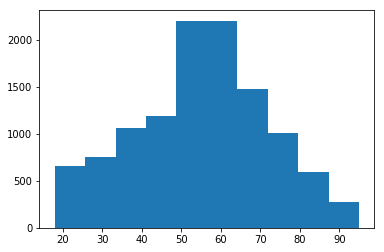

In [52]:
plt.hist(df_demo.age);

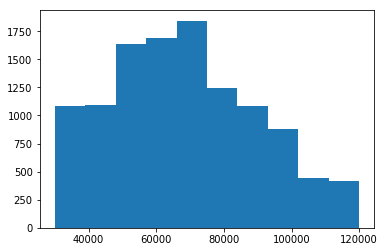

In [53]:
plt.hist(df_demo.income);

In [54]:
df_demo.gender.value_counts()[0]/df_demo.gender.count()

0.5341745531019979

In [55]:
df_demo.gender.value_counts()[1]/df_demo.gender.count()

0.4506659656501928

In [56]:
df.gender.value_counts()[0]/df.gender.count()

0.571537341101695

In [57]:
df.gender.value_counts()[1]/df.gender.count()

0.4139264065442561

In [58]:
user_ids_view_complete = df_demo['user_id'].tolist()

In [59]:
df_viewed_copy.head()

,event,user_id,time_viewed,offer_id_viewed
1,offer viewed,2.0,6,4
6,offer viewed,2.0,216,8
11,offer viewed,2.0,408,1
17,offer viewed,2.0,582,9
19,offer viewed,3.0,18,10


In [60]:
df_completed.head()

,event,user_id,time_completed,age,gender,income,offer_id_completed,reward
3,offer completed,2.0,132,75,F,100000.0,4,5
14,offer completed,2.0,510,75,F,100000.0,1,10
15,offer completed,2.0,510,75,F,100000.0,9,5
28,offer completed,3.0,522,68,M,70000.0,4,5
29,offer completed,3.0,522,68,M,70000.0,7,2


In [61]:
df_viewed_only = df_viewed_copy.merge(df_completed, on=['user_id'], how='outer')

In [62]:
df_viewed_only

,event_x,user_id,time_viewed,offer_id_viewed,event_y,time_completed,age,gender,income,offer_id_completed,reward
0,offer viewed,2.0,6.0,4.0,offer completed,132.0,75.0,F,100000.0,4.0,5.0
1,offer viewed,2.0,6.0,4.0,offer completed,510.0,75.0,F,100000.0,1.0,10.0
2,offer viewed,2.0,6.0,4.0,offer completed,510.0,75.0,F,100000.0,9.0,5.0
3,offer viewed,2.0,216.0,8.0,offer completed,132.0,75.0,F,100000.0,4.0,5.0
4,offer viewed,2.0,216.0,8.0,offer completed,510.0,75.0,F,100000.0,1.0,10.0
5,offer viewed,2.0,216.0,8.0,offer completed,510.0,75.0,F,100000.0,9.0,5.0
6,offer viewed,2.0,408.0,1.0,offer completed,132.0,75.0,F,100000.0,4.0,5.0
7,offer viewed,2.0,408.0,1.0,offer completed,510.0,75.0,F,100000.0,1.0,10.0
8,offer viewed,2.0,408.0,1.0,offer completed,510.0,75.0,F,100000.0,9.0,5.0
9,offer viewed,2.0,582.0,9.0,offer completed,132.0,75.0,F,100000.0,4.0,5.0


In [63]:
df_viewed_only = df_viewed_only.dropna(subset=['event_x'])

In [64]:
df_viewed_only = df_viewed_only[df_viewed_only['event_y'].isna()]

In [65]:
del df_viewed_only['event_y']
del df_viewed_only['reward']
del df_viewed_only['time_completed']
del df_viewed_only['offer_id_completed']

In [66]:
del df_viewed_only['gender']
del df_viewed_only['age']
del df_viewed_only['income']

In [67]:
profile.head()

,age,gender,income,user_id
1,55,F,112000.0,1
3,75,F,100000.0,2
5,68,M,70000.0,3
8,65,M,53000.0,4
12,58,M,51000.0,5


In [68]:
df_viewed_only = df_viewed_only.merge(profile, on='user_id')

In [69]:
df_viewed_only

,event_x,user_id,time_viewed,offer_id_viewed,age,gender,income
0,offer viewed,28.0,0.0,1.0,20,F,30000.0
1,offer viewed,64.0,0.0,9.0,40,M,53000.0
2,offer viewed,64.0,336.0,9.0,40,M,53000.0
3,offer viewed,64.0,504.0,8.0,40,M,53000.0
4,offer viewed,70.0,18.0,9.0,70,F,74000.0
5,offer viewed,70.0,414.0,9.0,70,F,74000.0
6,offer viewed,70.0,588.0,6.0,70,F,74000.0
7,offer viewed,80.0,66.0,2.0,45,M,54000.0
8,offer viewed,80.0,210.0,1.0,45,M,54000.0
9,offer viewed,80.0,420.0,7.0,45,M,54000.0


In [70]:
view_demo = df_viewed_only.drop_duplicates(subset='user_id')
user_ids_view_only = view_demo['user_id'].tolist()

In [71]:
view_demo

,event_x,user_id,time_viewed,offer_id_viewed,age,gender,income
0,offer viewed,28.0,0.0,1.0,20,F,30000.0
1,offer viewed,64.0,0.0,9.0,40,M,53000.0
4,offer viewed,70.0,18.0,9.0,70,F,74000.0
7,offer viewed,80.0,66.0,2.0,45,M,54000.0
10,offer viewed,558.0,354.0,2.0,53,M,95000.0
11,offer viewed,98.0,12.0,3.0,71,M,57000.0
14,offer viewed,100.0,24.0,8.0,83,M,46000.0
19,offer viewed,101.0,18.0,6.0,26,M,71000.0
22,offer viewed,119.0,36.0,9.0,20,M,69000.0
24,offer viewed,125.0,0.0,8.0,68,M,58000.0


In [73]:
user_ids_view_complete

[2,
 3,
 4,
 5,
 6,
 8,
 13,
 14,
 11699,
 15,
 16,
 19,
 22,
 23,
 24,
 26,
 27,
 29,
 32,
 33,
 35,
 36,
 252,
 258,
 39,
 267,
 40,
 43,
 44,
 8600,
 47,
 48,
 49,
 51,
 53,
 54,
 55,
 56,
 58,
 379,
 63,
 65,
 66,
 12336,
 68,
 69,
 71,
 30,
 471,
 75,
 76,
 77,
 81,
 82,
 83,
 84,
 85,
 86,
 88,
 89,
 90,
 92,
 93,
 96,
 97,
 99,
 102,
 634,
 105,
 106,
 108,
 666,
 114,
 117,
 118,
 3648,
 123,
 126,
 128,
 130,
 132,
 133,
 134,
 135,
 556,
 138,
 140,
 141,
 142,
 143,
 144,
 903,
 151,
 153,
 159,
 162,
 4905,
 165,
 167,
 168,
 170,
 1071,
 174,
 175,
 1091,
 4907,
 179,
 183,
 185,
 186,
 190,
 191,
 194,
 196,
 11740,
 198,
 200,
 201,
 205,
 206,
 209,
 210,
 212,
 213,
 214,
 215,
 216,
 218,
 220,
 223,
 224,
 225,
 226,
 234,
 235,
 238,
 239,
 240,
 242,
 243,
 244,
 1037,
 246,
 247,
 249,
 250,
 5979,
 253,
 255,
 256,
 259,
 260,
 263,
 266,
 269,
 270,
 271,
 272,
 273,
 278,
 280,
 281,
 282,
 283,
 284,
 286,
 11508,
 1753,
 288,
 1758,
 289,
 292,
 293,
 295,
 2

In [74]:
user_ids_view_only

[28.0,
 64.0,
 70.0,
 80.0,
 558.0,
 98.0,
 100.0,
 101.0,
 119.0,
 125.0,
 127.0,
 131.0,
 136.0,
 146.0,
 163.0,
 164.0,
 166.0,
 169.0,
 178.0,
 182.0,
 184.0,
 189.0,
 195.0,
 199.0,
 208.0,
 14312.0,
 230.0,
 257.0,
 261.0,
 265.0,
 290.0,
 294.0,
 9982.0,
 13331.0,
 3945.0,
 2081.0,
 343.0,
 353.0,
 355.0,
 364.0,
 366.0,
 378.0,
 388.0,
 408.0,
 2455.0,
 415.0,
 772.0,
 421.0,
 425.0,
 431.0,
 444.0,
 447.0,
 2727.0,
 2932.0,
 9914.0,
 517.0,
 518.0,
 534.0,
 542.0,
 6221.0,
 562.0,
 563.0,
 566.0,
 13004.0,
 581.0,
 582.0,
 3447.0,
 590.0,
 593.0,
 599.0,
 605.0,
 615.0,
 623.0,
 625.0,
 629.0,
 649.0,
 650.0,
 651.0,
 3879.0,
 657.0,
 1111.0,
 670.0,
 696.0,
 705.0,
 1375.0,
 725.0,
 727.0,
 733.0,
 736.0,
 745.0,
 769.0,
 770.0,
 775.0,
 779.0,
 786.0,
 788.0,
 4791.0,
 792.0,
 10234.0,
 6682.0,
 811.0,
 1073.0,
 819.0,
 5032.0,
 12467.0,
 839.0,
 845.0,
 852.0,
 854.0,
 861.0,
 866.0,
 876.0,
 884.0,
 886.0,
 888.0,
 891.0,
 5106.0,
 901.0,
 916.0,
 918.0,
 923.0,
 930.0,
 2

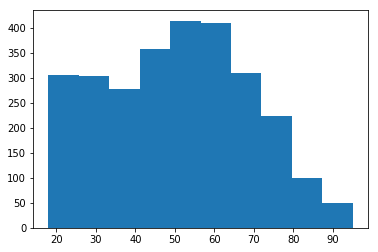

In [75]:
plt.hist(view_demo.age);

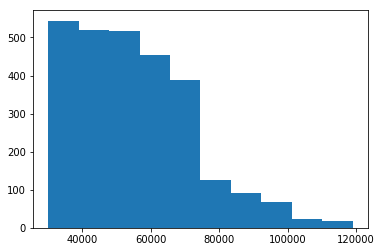

In [76]:
plt.hist(view_demo.income);